In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('NBA_dataset_new.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9898 entries, 0 to 9897
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          9898 non-null   int64  
 1   Player              9898 non-null   object 
 2   G                   9898 non-null   float64
 3   GS                  9898 non-null   float64
 4   MP                  9898 non-null   float64
 5   FG                  9898 non-null   float64
 6   FGA                 9898 non-null   float64
 7   3P                  9898 non-null   float64
 8   3PA                 9898 non-null   float64
 9   2P                  9898 non-null   float64
 10  2PA                 9898 non-null   float64
 11  FT                  9898 non-null   float64
 12  FTA                 9898 non-null   float64
 13  ORB                 9898 non-null   float64
 14  DRB                 9898 non-null   float64
 15  TRB                 9898 non-null   float64
 16  AST   

In [4]:
def drop_missing_values(df, col):
    df.dropna(subset=[col], inplace=True)
    return df

In [5]:
for column in df.columns:
    drop_missing_values(df, column)

In [6]:
df.head()

,Unnamed: 0,Player,G,GS,MP,FG,FGA,3P,3PA,2P,...,3P%,2P%,eFG%,FT%,Pos,height,weight,seasonStartYear,salary,inflationAdjSalary
0,0,A.C. Green,82.0,82.0,2709.0,385.0,806.0,13.0,46.0,372.0,...,0.283,0.489,0.486,0.751,PF,203.0,106.0,1990,1750000,3991872
1,1,A.C. Green,82.0,21.0,2164.0,258.0,542.0,11.0,55.0,247.0,...,0.200,0.507,0.486,0.738,PF,203.0,106.0,1991,1750000,3812825
2,2,A.C. Green,82.0,53.0,2902.0,382.0,803.0,12.0,56.0,370.0,...,0.214,0.495,0.483,0.744,PF,203.0,106.0,1992,1750000,3698603
3,3,A.C. Green,82.0,55.0,2819.0,379.0,706.0,16.0,46.0,363.0,...,0.348,0.550,0.548,0.739,PF,203.0,106.0,1993,1885000,3868048
4,4,A.C. Green,82.0,55.0,2825.0,465.0,926.0,8.0,35.0,457.0,...,0.229,0.513,0.506,0.735,PF,203.0,106.0,1994,6472600,12958801


In [7]:
df.shape

(8516, 54)

In [8]:
df.drop(df.columns[0], axis=1, inplace=True)
df.drop(columns='salary', inplace=True)

In [9]:
df['Pos'] = df['Pos'].astype('category')
df['Pos_code'] = df['Pos'].cat.codes
df.head()

,Player,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,...,3P%,2P%,eFG%,FT%,Pos,height,weight,seasonStartYear,inflationAdjSalary,Pos_code
0,A.C. Green,82.0,82.0,2709.0,385.0,806.0,13.0,46.0,372.0,760.0,...,0.283,0.489,0.486,0.751,PF,203.0,106.0,1990,3991872,2
1,A.C. Green,82.0,21.0,2164.0,258.0,542.0,11.0,55.0,247.0,487.0,...,0.200,0.507,0.486,0.738,PF,203.0,106.0,1991,3812825,2
2,A.C. Green,82.0,53.0,2902.0,382.0,803.0,12.0,56.0,370.0,747.0,...,0.214,0.495,0.483,0.744,PF,203.0,106.0,1992,3698603,2
3,A.C. Green,82.0,55.0,2819.0,379.0,706.0,16.0,46.0,363.0,660.0,...,0.348,0.550,0.548,0.739,PF,203.0,106.0,1993,3868048,2
4,A.C. Green,82.0,55.0,2825.0,465.0,926.0,8.0,35.0,457.0,891.0,...,0.229,0.513,0.506,0.735,PF,203.0,106.0,1994,12958801,2


In [10]:
df_numeric = df.select_dtypes(include='number')
corr = df_numeric.corr()
inflationAdjSalary_corr = corr['inflationAdjSalary'].sort_values(ascending=False)
# inflationAdjSalary_corr[:11]

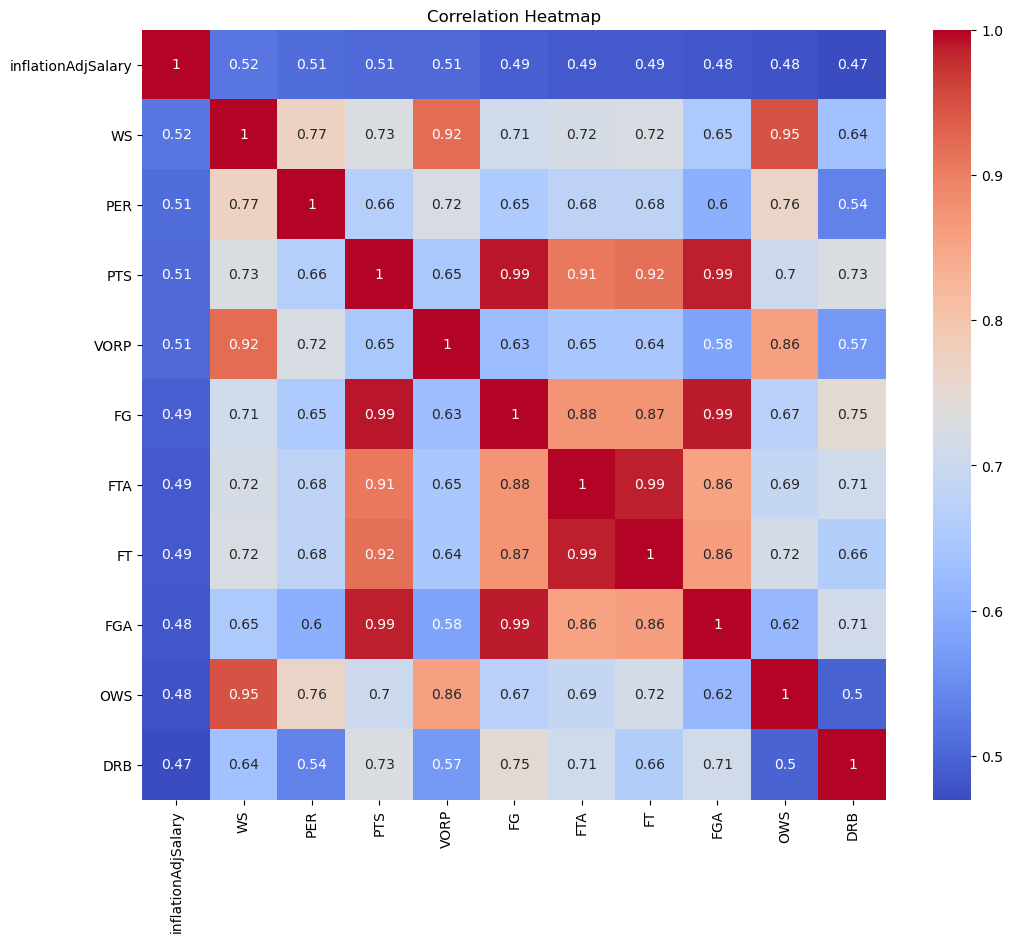

In [11]:
fig, ax = plt.subplots(figsize=(12,10))
features = inflationAdjSalary_corr.index[:11]

df_select = df[features]

corr = df_select.corr()

# Generate a heatmap of the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Heatmap')
plt.show()

In [12]:
def remove_outliers(df, column_name):
    """
    Remove outliers from a given column in a pandas DataFrame.

    Parameters:
    df (pandas.DataFrame): the input DataFrame
    column_name (str): the name of the column to remove outliers from

    Returns:
    pandas.DataFrame: the DataFrame with outliers removed
    """
    # Calculate the first and third quartiles
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)

    # Calculate the interquartile range
    iqr = q3 - q1

    # Define the outlier range
    outlier_range = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

    # Remove outliers from the specified column
    df = df[(df[column_name] >= outlier_range[0]) & (df[column_name] <= outlier_range[1])]

    return df

In [13]:
for column in features:
    df = remove_outliers(df, column)

In [14]:
df.shape

(6409, 53)

# Train

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

def mae(y_true, y_pred):
    mae_score = mean_absolute_error(y_true, y_pred)
    return mae_score

def rmse(y_true, y_pred):
    rmse_score = mean_squared_error(y_true, y_pred, squared=False)
    return rmse_score

def r2(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    return r2

def plot_curves(model):
    train_errors = []
    val_errors = []
    batch_size = 100
    train_sizes = []
    for i in range(batch_size, len(X_train)+1, batch_size):
        train_sizes.append(i)
        lr.fit(X_train[:i], y_train[:i])
        y_train_pred = lr.predict(X_train[:i])
        y_val_pred = lr.predict(X_val)

        train_error = mae(y_train[:i], y_train_pred)
        val_error = mae(y_val, y_val_pred)
        train_errors.append(train_error)
        val_errors.append(val_error)
    plt.plot(train_sizes, train_errors)
    plt.plot(train_sizes, val_errors)
    plt.show()

def train(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def evaluate(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print("mae: ", mae(y_val, y_pred))
    print("r2: ", r2(y_val, y_pred))
    print("rmse: ", rmse(y_val, y_pred))

In [16]:
new_df = df_numeric[features]
# new_df = df_numeric.dropna().reset_index(drop=True)
X = new_df.loc[:, ~new_df.columns.isin(['inflationAdjSalary'])]

y = new_df.loc[:, new_df.columns.isin(['inflationAdjSalary'])]

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [17]:
lr = LinearRegression()
lr = train(lr, X_train, y_train)
evaluate(lr, X_train, y_train)
evaluate(lr, X_val, y_val)

mae:  3612229.9497144967
r2:  0.3528507467340527
rmse:  5084494.844252467
mae:  3799337.202817964
r2:  0.35225639902517203
rmse:  5350605.339270767


In [18]:
ridge = Ridge()
ridge = train(ridge, X_train, y_train)
evaluate(ridge, X_train, y_train)
evaluate(ridge, X_val, y_val)

mae:  3616443.1288263677
r2:  0.3473595819446532
rmse:  5106020.653698751
mae:  3795398.936682947
r2:  0.35219715953403163
rmse:  5350850.003896072


In [19]:
lasso = Lasso()
lasso = train(lasso, X_train, y_train)
evaluate(lasso, X_train, y_train)
evaluate(lasso, X_val, y_val)

mae:  3612269.6134585585
r2:  0.35285010262217054
rmse:  5084497.374567315
mae:  3799305.561440033
r2:  0.35222513550171175
rmse:  5350734.461933583


In [20]:
rf = RandomForestRegressor()
rf = train(rf, X_train, y_train)
evaluate(rf, X_train, y_train)
evaluate(rf, X_val, y_val)

mae:  1305798.6155812782
r2:  0.9124047182654256
rmse:  1870621.583521221
mae:  3759001.641499021
r2:  0.3523954489854758
rmse:  5350031.006007142


In [21]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2) 
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.fit_transform(X_val)

lr = LinearRegression()
lr = train(lr, X_train_poly, y_train)
evaluate(lr, X_train_poly, y_train)
evaluate(lr, X_val_poly, y_val)

mae:  3298967.5871415366
r2:  0.4390419321915586
rmse:  4733809.570563506
mae:  3539954.0956195677
r2:  0.40711886622725013
rmse:  5119000.456947705
